In [65]:
!pip install imblearn
!pip install seaborn

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Load dataset
input_file_path = '../data/feature_extraction/BERT_Features.csv'
df = pd.read_csv(input_file_path)

X = df.iloc[:, 7:].values  # BERT features start from the 8th column
y = df['Sentiment']

# Encoding categorical labels
y_encoded = pd.get_dummies(y).values

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the sampling strategy
sampling_strategy = {0: df['Sentiment'].value_counts()['negative'], 1: df['Sentiment'].value_counts()['neutral'],
                     2: df['Sentiment'].value_counts()['positive']}

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy, k_neighbors=10)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Reshape X to have 3 dimensions [samples, timesteps, features]
# Assuming each sample is a single timestep
X_train_smote = np.expand_dims(X_train_smote, axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Define your LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_smote.shape[1], X_train_smote.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y_train_smote.shape[1], activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_smote, y_train_smote, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

(5649, 1, 768)
Epoch 1/20
142/142 [==============================] - 2s 4ms/step - loss: 0.6871 - accuracy: 0.6867 - val_loss: 0.5252 - val_accuracy: 0.7965
Epoch 2/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5930 - accuracy: 0.7561 - val_loss: 0.4978 - val_accuracy: 0.7982
Epoch 3/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.7659 - val_loss: 0.4738 - val_accuracy: 0.8159
Epoch 4/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5667 - accuracy: 0.7716 - val_loss: 0.4604 - val_accuracy: 0.8212
Epoch 5/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5488 - accuracy: 0.7816 - val_loss: 0.4485 - val_accuracy: 0.8319
Epoch 6/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5340 - accuracy: 0.7887 - val_loss: 0.4414 - val_accuracy: 0.8336
Epoch 7/20
142/142 [==============================] - 0s 2ms/step - loss: 0.5186 - accuracy: 0.7927 - val_loss: 0.4138 - val_accuracy

In [67]:
print("Negative:", y.value_counts()['negative'])
print("Neutral:", y.value_counts()['neutral'])
print("Positive:", y.value_counts()['positive'])

Negative: 3281
Neutral: 152
Positive: 2216


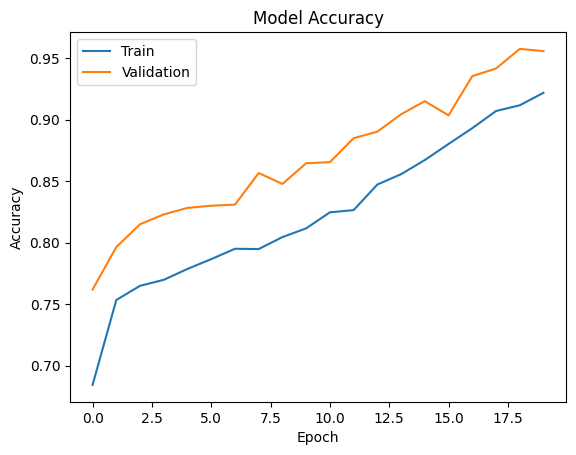

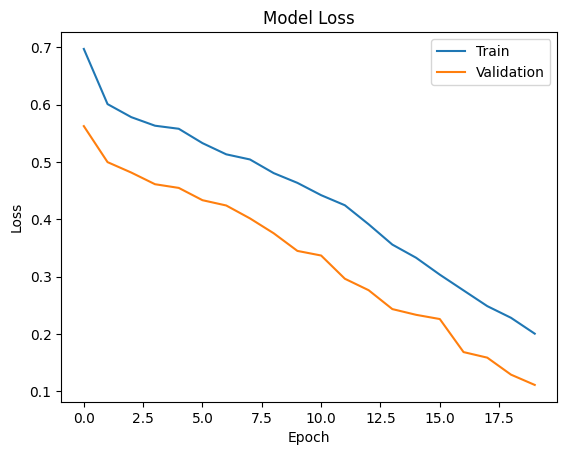

In [68]:
import matplotlib.pyplot as plt

# Plotting the accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [69]:
import pickle
pickle.dump(model, open('../model/lstm_model.pkl', 'wb'))

36/36 [==============================] - 0s 694us/step


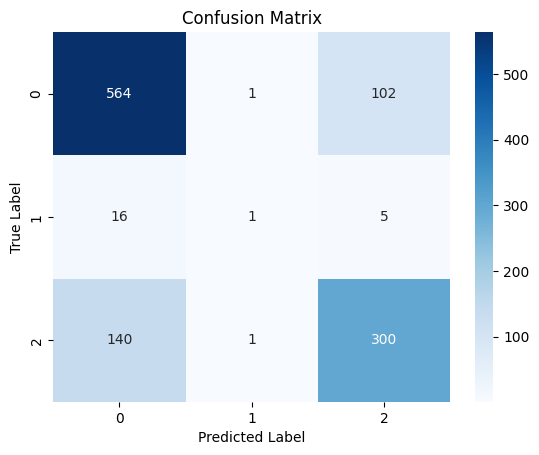

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       667
           1       0.33      0.05      0.08        22
           2       0.74      0.68      0.71       441

    accuracy                           0.77      1130
   macro avg       0.62      0.52      0.53      1130
weighted avg       0.76      0.77      0.76      1130



In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Printing classification report
print(classification_report(y_true, y_pred_classes))


In [71]:
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emoji import demojize
import re
from transformers import BertTokenizer, BertModel

slang_dict = {
    'btw': 'by the way',
    'lol': 'laughing out loud',
    'idk': 'I do not know',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'brb': 'be right back',
    'tbh': 'to be honest',
    'lmao': 'laughing my ass off',
    'rofl': 'rolling on the floor laughing',
    'smh': 'shaking my head',
    'omg': 'oh my god',
    'ttyl': 'talk to you later',
    'afaik': 'as far as I know',
    'irl': 'in real life',
    'thx': 'thanks',
    'pls': 'please',
    'dm': 'direct message',
    'fyi': 'for your information',
    'b4': 'before',
    'gr8': 'great',
    'u': 'you',
    'r': 'are',
    'yolo': 'you only live once',
    'np': 'no problem',
    'g2g': 'got to go',
    'tldr': 'too long, didn’t read',
    'jk': 'just kidding',
    'bff': 'best friends forever',
    'icymi': 'in case you missed it',
    'fomo': 'fear of missing out',
    'ftw': 'for the win',
    'wtf': 'what the f***',
    'nsfw': 'not safe for work',
    'nbd': 'no big deal',
    'faq': 'frequently asked questions',
    'afk': 'away from keyboard',
    'asap': 'as soon as possible'
}

# Function to extract and process hashtags
def process_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return ' '.join(hashtags)

# Function to preprocess the input text
def preprocess_text(text):
    # Convert emojis to text and process hashtags
    text = demojize(text) + ' ' + process_hashtags(text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and apply lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words]

    # Translate slang
    tokens = [slang_dict.get(token, token) for token in tokens]

    # Remove non-alphabetic characters and keep the tokens
    tokens = [token for token in tokens if token.isalpha()]

    return ' '.join(tokens)

# Function to predict the sentiment of the input text
def predict_sentiment(text):
    # Preprocess the input text
    preprocessed_text = preprocess_text(text)

    # Load the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Load the BERT model
    bert_model = BertModel.from_pretrained('bert-base-uncased')

    # Function to encode text using BERT
    def bert_encode(text):
        inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
        outputs = bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].detach().numpy() # bert model will contain the inputs and the output will be the last hidden state

    # Reshape the BERT features
    bert_features = bert_encode(preprocessed_text)
    bert_features = np.expand_dims(bert_features, axis=1)

    # Make the prediction using the trained LSTM model
    sentiment_probabilities = model(bert_features)  # Fix: Add the missing model prediction code here
    predicted_sentiment = np.argmax(sentiment_probabilities, axis=1)
    encoded_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = encoded_labels[predicted_sentiment[0]]
    
    return predicted_sentiment

# Get the input text from the user
input_text = input("Enter the text: ")

# Predict the sentiment of the input text
predicted_sentiment = predict_sentiment(input_text)

# Print the predicted sentiment
print("Predicted Sentiment:", predicted_sentiment)


Predicted Sentiment: Positive
